## Model Training and Evaluation

Multiple machine learning models are trained to predict the target variable.  

We evaluate all models using two metrics:
- RMSE (Root Mean Squared Error): Lower is better.
- R² Score: Closer to 1 means better fit.

Finally, we compare all models side by side to identify which one performs best on validation data.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

## Warning Suppression

To keep the notebook output clean and easy to read, warning messages are turned off using Python’s `warnings` module.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Loading

The training, test, and sample submission files are loaded from the given Kaggle directory.  
A `try-except` block is used to handle missing or incorrect file paths gracefully.

Once the files are successfully loaded, copies of the training and test datasets are created to preserve the original data for reference.


In [3]:
try:
    train_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
    test_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')
    sample_submission = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv')

except FileNotFoundError:
    print("Recheck your dataset paths")

train_df_processed = train_df.copy()
test_df_processed = test_df.copy()

## Basic Information

This section displays the structure of the training dataset.  
It includes the column names, data types, and non-null counts to help understand the overall shape and completeness of the data.


In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40000 non-null  int64  
 1   airline      35387 non-null  object 
 2   flight       40000 non-null  object 
 3   source       40000 non-null  object 
 4   departure    35208 non-null  object 
 5   stops        37681 non-null  object 
 6   arrival      40000 non-null  object 
 7   destination  40000 non-null  object 
 8   class        40000 non-null  object 
 9   duration     36987 non-null  float64
 10  days_left    35562 non-null  float64
 11  price        40000 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB
None


## Descriptive Statistics

This section provides summary statistics for all numerical columns in the training dataset.  
It includes metrics such as count, mean, standard deviation, minimum, and maximum values.  
These help identify the range and distribution of the data, as well as any potential outliers.


In [5]:
print(train_df.describe())

                id      duration     days_left         price
count  40000.00000  36987.000000  35562.000000   40000.00000
mean   19999.50000     12.004088     26.197936   20801.49025
std    11547.14972      7.108063     13.469232   22729.14842
min        0.00000      0.830000      1.000000    1105.00000
25%     9999.75000      6.670000     15.000000    4687.00000
50%    19999.50000     11.080000     26.000000    7353.00000
75%    29999.25000     15.920000     38.000000   42521.00000
max    39999.00000     47.080000     49.000000  114704.00000


## Checking for Missing Values and Duplicates

Before we begin preprocessing, it's important to check for any missing values or duplicate rows in the dataset.  
This helps us understand if any cleaning is required before model training.


In [6]:
print(f"\nMissing values:\n{train_df.isnull().sum()}")
print(f"\nDuplicates in dataset: {train_df.duplicated().sum()}")


Missing values:
id                0
airline        4613
flight            0
source            0
departure      4792
stops          2319
arrival           0
destination       0
class             0
duration       3013
days_left      4438
price             0
dtype: int64

Duplicates in dataset: 0


## Visualizing Missing Values

To better understand the data quality, we plot a heatmap showing the locations of missing values in the dataset.  
This gives a quick visual overview of where data might be incomplete.


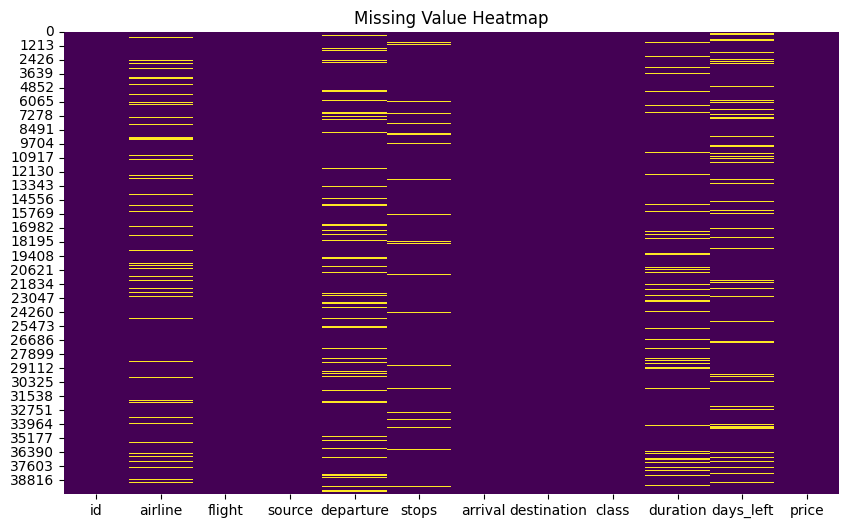

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

## Price Distribution

We plot a histogram of the `price` column to understand how prices are distributed in the training dataset.  
This helps identify skewness, outliers, or any unusual patterns in the target variable.


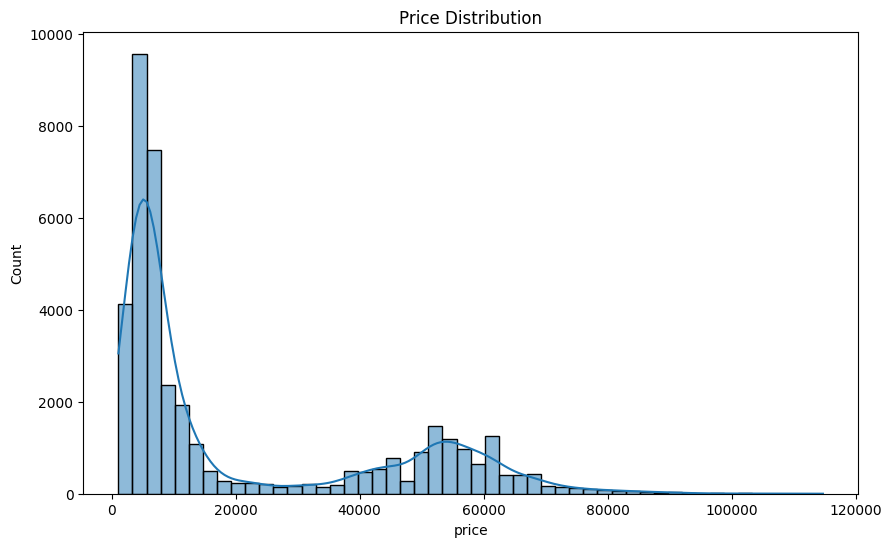

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(train_df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.show()

## Flights per Airline

This bar chart shows how many flight records exist for each airline in the dataset.  
It helps us understand which airlines appear more frequently and gives a sense of data distribution across different carriers.



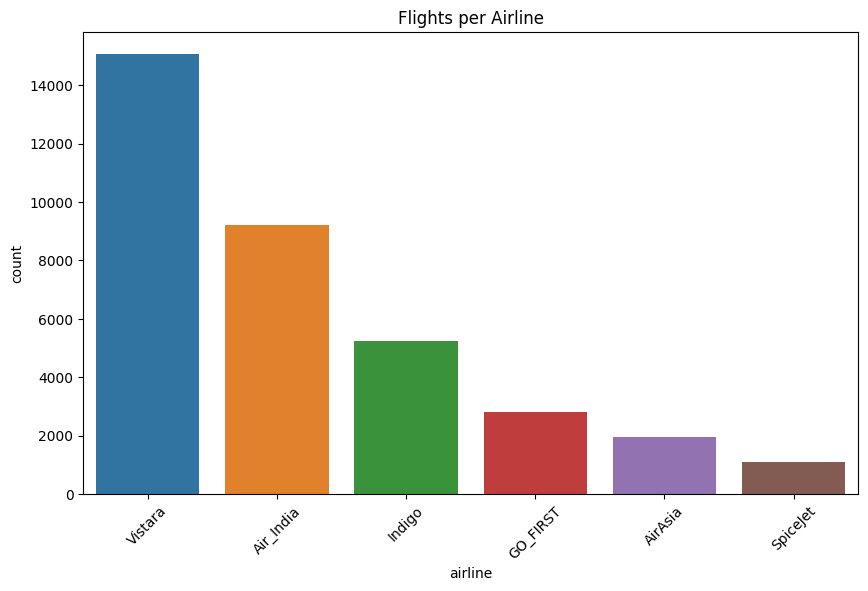

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, x='airline', order=train_df['airline'].value_counts().index)
plt.title('Flights per Airline')
plt.xticks(rotation=45)
plt.show()

## Airline vs Ticket Price

This boxplot shows how ticket prices vary across different airlines.  
It helps us compare the price range, median price, and presence of outliers for each airline.


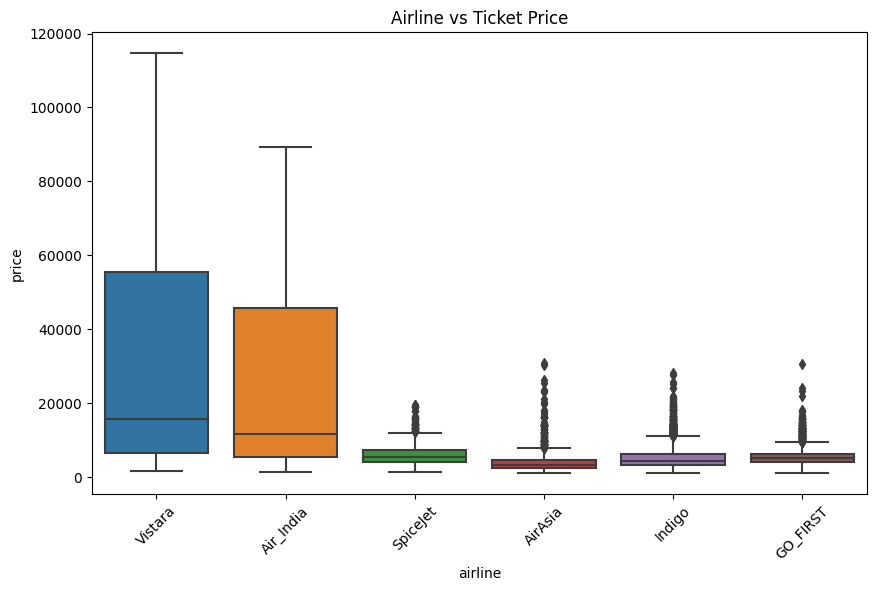

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(data=train_df, x='airline', y='price')
plt.title('Airline vs Ticket Price')
plt.xticks(rotation=45)
plt.show()

## Class vs Ticket Price

This boxplot compares ticket prices for different travel classes.  
It helps visualize how prices differ between Economy, Business, and other classes.


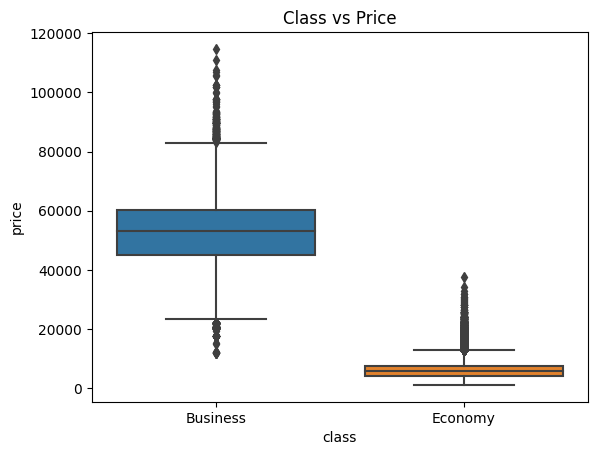

In [11]:
sns.boxplot(data=train_df, x='class', y='price')
plt.title("Class vs Price")
plt.show()

## Relationship Between Days Left and Price

This scatter plot shows how the number of days left before departure affects the ticket price.  
Each point represents a booking, with more recent bookings (lower days left) often priced higher.


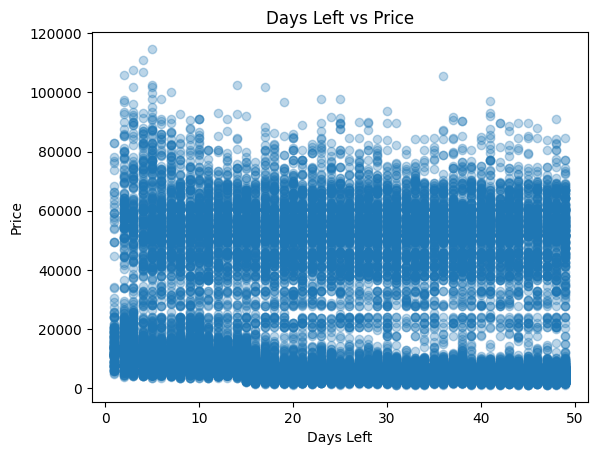

In [12]:
plt.scatter(train_df['days_left'], train_df['price'], alpha=0.3)
plt.title('Days Left vs Price')
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.show()

## Correlation Heatmap

This heatmap shows how different numerical features in the dataset are related to each other.  
It helps identify which features have strong positive or negative relationships, useful for understanding the data better before modeling.


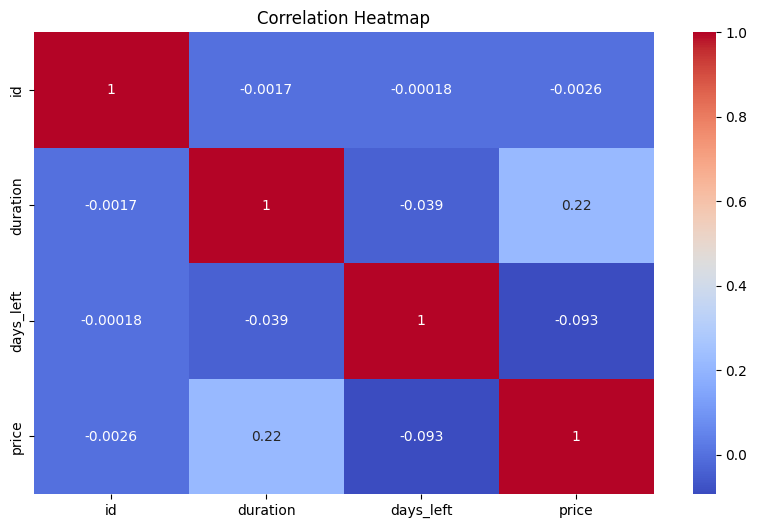

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Handling Missing Values and Outliers

Missing values in numerical columns like `duration` and `days_left` are filled using K-Nearest Neighbors (KNN) imputation.  
To improve model accuracy, outliers in `duration` and `price` are removed using the Interquartile Range (IQR) method.  
This helps in cleaning the dataset and reducing the effect of extreme values.


In [14]:
knn_imputer = KNNImputer(n_neighbors=5)
num_cols = ['duration', 'days_left']
train_df[num_cols] = knn_imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = knn_imputer.transform(test_df[num_cols])

for col in ['duration', 'price']:
    Q1, Q3 = train_df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    train_df = train_df[(train_df[col] >= lower) & (train_df[col] <= upper)]

## Encoding and Feature Scaling

Categorical columns like `airline`, `source`, `destination`, and others are converted to numbers using Label Encoding.  
Then, numerical columns such as `duration` and `days_left` are scaled using Standard Scaler to normalize the values.  
This prepares the dataset for training by ensuring all features are in a suitable format and range for the models.


In [15]:
label_cols = ['airline', 'source', 'destination', 'departure', 'arrival', 'stops', 'class']
le = LabelEncoder()
for col in label_cols:
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

features = label_cols + num_cols
X = train_df[features]
y = train_df['price']
X_test = test_df[features]

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Splitting the Data

The dataset is split into training and validation sets.  
80% of the data is used to train the models, and 20% is kept aside to test how well the models perform on unseen data.  
This helps in evaluating the model's ability to generalize.


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Scaling

We scale the numerical features `duration` and `days_left` using Standard Scaler.  
This ensures that these values are on the same scale, which helps many machine learning models perform better.  
The scaler is fitted on the training data and then applied to the validation and test sets.


In [17]:
scaler = StandardScaler()
X_train[['duration', 'days_left']] = scaler.fit_transform(X_train[['duration', 'days_left']])
X_val[['duration', 'days_left']] = scaler.transform(X_val[['duration', 'days_left']])
X_test[['duration', 'days_left']] = scaler.transform(X_test[['duration', 'days_left']])

## Feature Selection

We remove features that have very little variation using a Variance Threshold.  
Features with almost the same values across all rows don't help the model learn well,  
so this step helps keep only the useful ones.


In [18]:
selector = VarianceThreshold(threshold=0.01)
X_train = selector.fit_transform(X_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

## Evaluation Function

This function helps us measure how well a model is performing.

It calculates:
- **RMSE (Root Mean Squared Error)**: Shows how far predictions are from actual values. Lower is better.
- **R² Score**: Tells how well the model explains the data. Closer to 1 is better.

It prints these metrics and returns them so we can compare different models easily.


In [19]:
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: RMSE = {rmse:.2f}, R² = {r2:.4f}")
    return rmse, r2

## Model Storage Setup

We create two empty dictionaries:
- `fitted_models` will store the trained models.
- `model_scores` will keep track of their evaluation metrics.

This helps us organize and compare all models later.


In [20]:
fitted_models = {}
model_scores = {}

## Linear Regression

We start by training a simple Linear Regression model.  
It helps us set a baseline for performance.  
After training, we evaluate how well it performs on the validation set and store both the model and its results.



In [21]:
print("\nLinear Regression")
lr = LinearRegression().fit(X_train, y_train)
fitted_models['lr'] = lr
model_scores['Linear Regression'] = evaluate_model(y_val, lr.predict(X_val), "Linear Regression")


Linear Regression
Linear Regression: RMSE = 7099.96, R² = 0.9021


## Decision Tree

Next, we train a Decision Tree Regressor.  
It can handle non-linear patterns better than Linear Regression.  
After training, we evaluate it on the validation data and store the model and its performance.


In [22]:
print("\nDecision Tree")
dt = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
fitted_models['dt'] = dt
model_scores['Decision Tree'] = evaluate_model(y_val, dt.predict(X_val), "Decision Tree")


Decision Tree
Decision Tree: RMSE = 5253.18, R² = 0.9464


## Random Forest (with Grid Search)

We now train a Random Forest model and use GridSearchCV to find the best combination of hyperparameters like the number of trees (`n_estimators`) and tree depth (`max_depth`).  
This model works well for both linear and complex patterns.  
After finding the best model, we evaluate its performance and store the results.


In [23]:
print("\nRandom Forest (GridSearch)")
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators':[100, 200],
    'max_depth':[None, 10, 20]
}, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
rf = rf_grid.best_estimator_
fitted_models['rf'] = rf
print("RF best params:", rf_grid.best_params_)
model_scores['Random Forest'] = evaluate_model(y_val, rf.predict(X_val), "Random Forest")


Random Forest (GridSearch)
RF best params: {'max_depth': None, 'n_estimators': 200}
Random Forest: RMSE = 3913.69, R² = 0.9702


## Gradient Boosting (with Grid Search)

We train a Gradient Boosting model using GridSearchCV to find the best combination of parameters like the number of trees, learning rate, and depth.  
This model builds trees sequentially, where each tree tries to correct the mistakes of the previous one.  
Once the best configuration is found, we evaluate and save the model's performance.


In [24]:
print("\nGradient Boosting (GridSearch)")
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), {
    'n_estimators':[100, 200],
    'learning_rate':[0.05, 0.1],
    'max_depth':[3, 5]
}, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
gb = gb_grid.best_estimator_
fitted_models['gb'] = gb
print("GB best params:", gb_grid.best_params_)
model_scores['Gradient Boosting'] = evaluate_model(y_val, gb.predict(X_val), "Gradient Boosting")


Gradient Boosting (GridSearch)
GB best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boosting: RMSE = 4541.31, R² = 0.9599


## XGBoost (with Grid Search)

We use XGBoost, a powerful and fast tree-based algorithm often used in machine learning competitions.  
To improve its performance, we apply GridSearchCV to find the best parameters like `n_estimators`, `learning_rate`, and `max_depth`.  
After selecting the best configuration, we evaluate the model on validation data and record the results.


In [25]:
print("\nXGBoost (GridSearch)")
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators':[100, 200],
    'learning_rate':[0.05, 0.1],
    'max_depth':[3, 5]
}, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
xgb = xgb_grid.best_estimator_
fitted_models['xgb'] = xgb
print("XGB best params:", xgb_grid.best_params_)
model_scores['XGBoost'] = evaluate_model(y_val, xgb.predict(X_val), "XGBoost")


XGBoost (GridSearch)
XGB best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
XGBoost: RMSE = 4546.53, R² = 0.9598


## K-Nearest Neighbors (with Grid Search)

We use K-Nearest Neighbors, a model that makes predictions based on the closest data points in the training set.  
To tune it, we perform a grid search over different values of neighbors (`n_neighbors`) and weighting strategies (`weights`).  
Once the best parameters are found, we evaluate the model and store its results.


In [26]:
print("\nK-Nearest Neighbors (GridSearch)")
knn_grid = GridSearchCV(KNeighborsRegressor(), {
    'n_neighbors':[3, 5, 7, 9],
    'weights':['uniform', 'distance']
}, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
knn = knn_grid.best_estimator_
fitted_models['knn'] = knn
print("KNN best params:", knn_grid.best_params_)
model_scores['KNN'] = evaluate_model(y_val, knn.predict(X_val), "KNN")


K-Nearest Neighbors (GridSearch)
KNN best params: {'n_neighbors': 5, 'weights': 'distance'}
KNN: RMSE = 7489.08, R² = 0.8910


## Support Vector Regressor

We apply Support Vector Regression, which is useful for capturing complex relationships by fitting the best possible boundary around the data.  
It is sensitive to feature scaling, so using standardized features helps it perform better.  
The model is trained and then evaluated on the validation set.


In [27]:
print("\nSupport Vector Regressor")
svr = SVR().fit(X_train, y_train)
fitted_models['svr'] = svr
model_scores['SVR'] = evaluate_model(y_val, svr.predict(X_val), "SVR")


Support Vector Regressor
SVR: RMSE = 26113.37, R² = -0.3247


## Model Comparison

After training all models, we compare them using two metrics:  
- **RMSE (Root Mean Squared Error)**: Lower is better.  
- **R² Score**: Higher is better, as it shows how well the model explains the variance in the data.

This helps us identify which model performs best overall.


In [28]:
results_df = pd.DataFrame(model_scores, index=['RMSE', 'R2']).T.sort_values(by='RMSE')
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                           RMSE        R2
Random Forest       3913.693574  0.970246
Gradient Boosting   4541.312223  0.959937
XGBoost             4546.529566  0.959845
Decision Tree       5253.184133  0.946393
Linear Regression   7099.963802  0.902076
KNN                 7489.081394  0.891048
SVR                26113.370304 -0.324654


## Final Model and Submission

We select **Random Forest** as the final model based on its strong performance on validation data.  
The model is retrained using the full training and validation sets to maximize learning.  
Finally, we make predictions on the test data and prepare the submission file.


In [29]:
print("\nChoosing Random Forest as final model based on performance.")
final = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None) 
final.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
final_preds = final.predict(X_test)

submission = sample_submission.copy()
submission['price'] = final_preds
submission.to_csv("submission.csv", index=False)
print("Submission file saved!")


Choosing Random Forest as final model based on performance.
Submission file saved!
